# Generative Adversarial Network Model

[Paper](https://arxiv.org/abs/1406.2661)

In [38]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [39]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
print ("Done......!")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Done......!


In [40]:
# Initialization Parameters
# hyper Params
num_steps = 70000
batch_size = 128
learning_rate = 0.0002

# Network Params
image_dim = 784 # 28*28 pixels
gen_hidden_dim = 256
disc_hidden_dim = 256
noise_dim = 100 # noise data points


In [41]:
# A custom initialization
def glorot_init(shape):
    return tf.random_normal(shape = shape, stddev = 1. /  tf.sqrt(shape[0]/ 2.))

In [42]:
# Store layers weights and bias
weights = {
    'gen_hidden1': tf.Variable(glorot_init([noise_dim, gen_hidden_dim])),
    'gen_out': tf.Variable(glorot_init([gen_hidden_dim, image_dim])),
    'disc_hidden1': tf.Variable(glorot_init([image_dim, disc_hidden_dim])),
    'disc_out': tf.Variable(glorot_init([disc_hidden_dim, 1])),
}

bias = {
    'gen_hidden1': tf.Variable(tf.zeros([gen_hidden_dim])),
    'gen_out': tf.Variable(tf.zeros([image_dim])),
    'disc_hidden1': tf.Variable(tf.zeros([disc_hidden_dim])),
    'disc_out': tf.Variable(tf.zeros([1])),
}

In [43]:
# Generator, only use one hidden layer
def generator(input_x_g):
    hidden_layer = tf.matmul(input_x_g, weights['gen_hidden1'])
    hidden_layer = tf.add(hidden_layer, bias['gen_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    
    output_layer = tf.matmul(hidden_layer, weights['gen_out'])
    output_layer = tf.add(output_layer, bias['gen_out'])
    output_layer = tf.nn.sigmoid(output_layer)
    
    return output_layer


# Discriminator
def discriminator(input_x_d):
    hidden_layer = tf.matmul(input_x_d, weights['disc_hidden1'])
    hidden_layer = tf.add(hidden_layer, bias['disc_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    
    output_layer = tf.matmul(hidden_layer, weights['disc_out'])
    output_layer = tf.add(output_layer, bias['disc_out'])
    output_layer = tf.nn.sigmoid(output_layer)
    
    return output_layer


 ## Training Neural Network


In [44]:
# Network inputs
gen_input = tf.placeholder(tf.float32, shape = [None, noise_dim], name = 'noise_input')
disc_input = tf.placeholder(tf.float32, shape = [None, image_dim], name = 'disc_input')

# Build Generator Network
gen_sample = generator(gen_input)

# Build two Discriminater Networks (one from noise inputs , one from generator samples)
disc_real = discriminator(disc_input)
disc_fake = discriminator(gen_sample)

# Build Loss functions
gen_loss = - tf.reduce_mean(tf.log(disc_fake))
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))

# Build Optimizers
gen_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
disc_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

# Training Variable for each optimizers
gen_vars = [weights['gen_hidden1'], weights['gen_out'],
            bias['gen_hidden1'], bias['gen_out']]

disc_vars = [weights['disc_hidden1'], weights['disc_out'],
             bias['disc_hidden1'], bias['disc_out']]

# Create training operations
train_gen = gen_optimizer.minimize(loss = gen_loss, var_list = gen_vars)
train_disc = disc_optimizer.minimize(loss = disc_loss, var_list = disc_vars)

# Initilalize the variable
init = tf.global_variables_initializer()

# Start train the GAN using tensorflow session

In [45]:
# define a session
sess = tf.Session()

# Run the initializer
sess.run(init)

# Start training
for i in range(1, num_steps + 1):
    # Prepare the data 
    # Get the next minibatch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size = batch_size)
    
    # generate the noise to feed to the generator
    noise_data = np.random.uniform(-1. , 1., size = [batch_size, noise_dim])
    
    # feed data to train
    feed_dict = {disc_input: batch_x, gen_input: noise_data}
    _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss], 
                            feed_dict = feed_dict)
    
    if i % 2000 == 0 or i == 1:
        print ('Step %i : Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))

Step 1 : Generator Loss: 0.594956, Discriminator Loss: 1.457956
Step 2000 : Generator Loss: 4.409376, Discriminator Loss: 0.055016
Step 4000 : Generator Loss: 3.751481, Discriminator Loss: 0.113306
Step 6000 : Generator Loss: 3.323075, Discriminator Loss: 0.224488
Step 8000 : Generator Loss: 4.111264, Discriminator Loss: 0.171802
Step 10000 : Generator Loss: 3.441031, Discriminator Loss: 0.165900
Step 12000 : Generator Loss: 3.010540, Discriminator Loss: 0.243625
Step 14000 : Generator Loss: 3.285085, Discriminator Loss: 0.386427
Step 16000 : Generator Loss: 3.193564, Discriminator Loss: 0.374900
Step 18000 : Generator Loss: 3.633550, Discriminator Loss: 0.323033
Step 20000 : Generator Loss: 3.736483, Discriminator Loss: 0.233892
Step 22000 : Generator Loss: 3.362568, Discriminator Loss: 0.292289
Step 24000 : Generator Loss: 4.248236, Discriminator Loss: 0.254472
Step 26000 : Generator Loss: 3.735533, Discriminator Loss: 0.390124
Step 28000 : Generator Loss: 3.067001, Discriminator Los

# Test the results

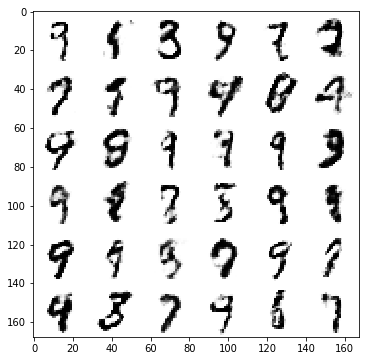

In [46]:
# Generate the image from noise, using the GAN network
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # noise input 
    noise_input = np.random.uniform(-1., 1., size = [n, noise_dim])
    
    # Generate image from noise
    gen_out = sess.run(gen_sample, feed_dict = {gen_input: noise_input})
    # Reserve the colours for better display
    gen_out = -1 * (gen_out - 1)
    for j in range(n):
        # display the image generated from GAN
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = gen_out[j].reshape([28, 28])
        
plt.figure(figsize=(n,n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()